![Henry Logo](https://www.soyhenry.com/_next/static/media/HenryLogo.bb57fd6f.svg)

# Introducción a las bases de datos vectoriales 
## Clase #3 :Text CLassification

In [ ]:
#!uv add datasets

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm

/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
EMBEDDING_MODEL = "text-embedding-3-small" # <-- Este es el que hay que cambiar 

In [3]:
# Cargando la bae. de datos de Rotten Tomatoes
dataset = load_dataset("rotten_tomatoes")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [5]:
train_data = dataset["train"].shuffle(seed=42).select(range(500))
test_data = dataset["test"].shuffle(seed=42).select(range(100))

In [6]:
def get_embeddings(texts, model=EMBEDDING_MODEL):
    texts = [t.replace("\n", " ") for t in texts]
    response = client.embeddings.create(input=texts, model=model)
    return [data.embedding for data in response.data]

In [7]:
X_train = get_embeddings(train_data["text"])
y_train = train_data["label"]

In [9]:
y_train

Column([0, 1, 0, 1, 0, ...])

In [10]:
X_test = get_embeddings(test_data["text"])
y_test = test_data["label"]

In [11]:
print("Calculando reducción de dimensionalidad (t-SNE)...")
X_embedded = np.array(X_train)

Calculando reducción de dimensionalidad (t-SNE)...


In [12]:
# Primero PCA para reducir ruido, luego t-SNE para estructura local
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_embedded)

In [13]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X_pca)

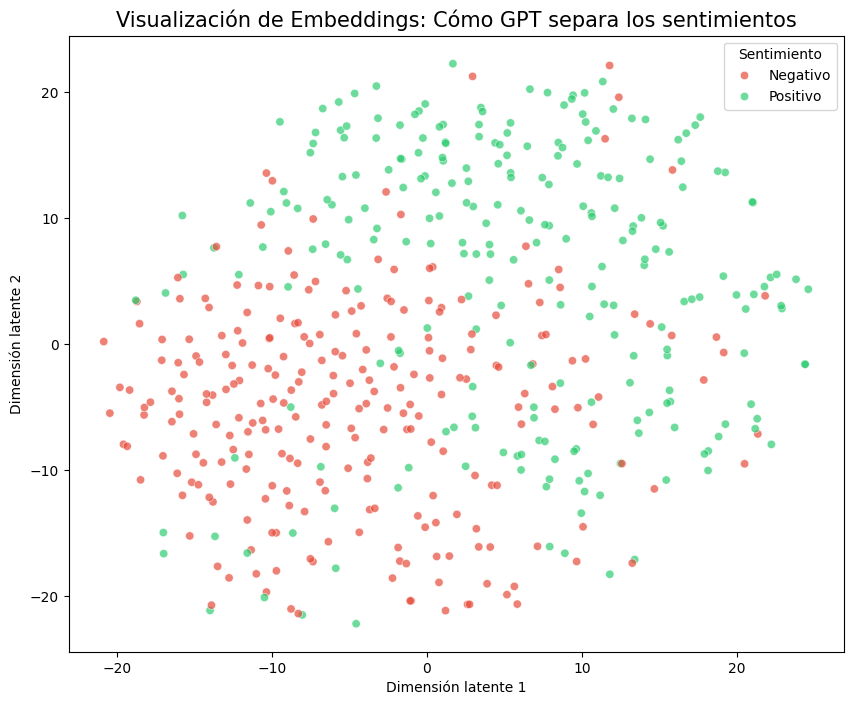

In [14]:
df_viz = pd.DataFrame(X_2d, columns=["x", "y"])
df_viz["label"] = ["Positivo" if l == 1 else "Negativo" for l in y_train]
df_viz["text"] = train_data["text"]


plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_viz, 
    x="x", y="y", 
    hue="label", 
    palette={"Positivo": "#2ecc71", "Negativo": "#e74c3c"},
    alpha=0.7
)
plt.title("Visualización de Embeddings: Cómo GPT separa los sentimientos", fontsize=15)
plt.xlabel("Dimensión latente 1")
plt.ylabel("Dimensión latente 2")
plt.legend(title="Sentimiento")
plt.show()

### Entrenando un modelo 

In [15]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [16]:
print("\n--- Reporte de Clasificación (Embeddings + Logistic Regression) ---")
print(classification_report(y_test, y_pred, target_names=["Negativo", "Positivo"]))


--- Reporte de Clasificación (Embeddings + Logistic Regression) ---
              precision    recall  f1-score   support

    Negativo       0.84      0.82      0.83        51
    Positivo       0.82      0.84      0.83        49

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



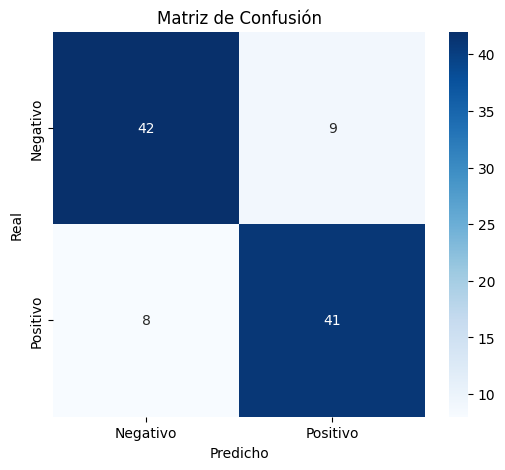

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Negativo", "Positivo"], 
            yticklabels=["Negativo", "Positivo"])
plt.title("Matriz de Confusión")
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

### Buscando un modelo con Params

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


In [29]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0, 0.5, 1],
    'solver': ['lbfgs', 'liblinear'], 
    'max_iter': [1000] 
}

In [30]:
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1, 
    verbose=1
)

In [31]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:490: FitFailedWarning: 
75 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlosdaniel/Documents/Projects/la

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.01, 0.1, ...], 'l1_ratio': [0, 0.5, ...], 'max_iter': [1000], 'solver': ['lbfgs', 'liblinear']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is

In [22]:
best_logreg = grid_search.best_estimator_

print("\n--- Resultados del Fine-Tuning ---")
print(f"Mejores Hiperparámetros: {grid_search.best_params_}")
print(f"Mejor Accuracy en Validación Cruzada: {grid_search.best_score_ * 100:.2f}%\n")



--- Resultados del Fine-Tuning ---
Mejores Hiperparámetros: {'C': 1, 'l1_ratio': 0, 'max_iter': 1000, 'solver': 'lbfgs'}
Mejor Accuracy en Validación Cruzada: 88.80%



In [23]:
y_pred_tuned = best_logreg.predict(X_test)

print("--- Reporte de Clasificación (LogReg Optimizado) ---")
print(classification_report(y_test, y_pred_tuned, target_names=["Negativo", "Positivo"]))

--- Reporte de Clasificación (LogReg Optimizado) ---
              precision    recall  f1-score   support

    Negativo       0.84      0.82      0.83        51
    Positivo       0.82      0.84      0.83        49

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



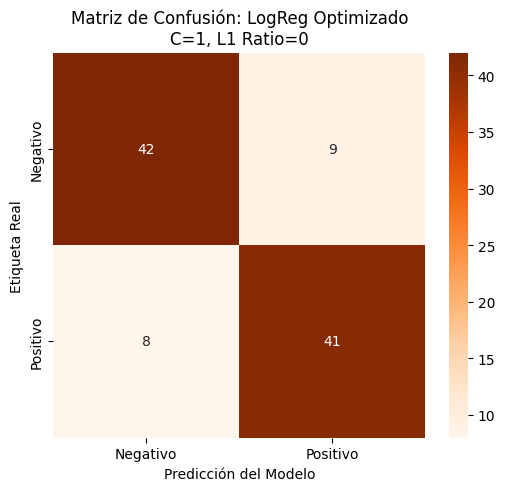

In [32]:
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=["Negativo", "Positivo"], 
            yticklabels=["Negativo", "Positivo"])
plt.title(f"Matriz de Confusión: LogReg Optimizado\nC={grid_search.best_params_['C']}, L1 Ratio={grid_search.best_params_['l1_ratio']}")
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción del Modelo')
plt.show()

### Haciendo la CLasificación con OpenAI 

In [34]:
def classify_review(text):
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "system", 
                    "content": "You are a helpful assistant for sentiment analysis. "
                               "Classify the following movie review strictly as 'Positive' or 'Negative'. "
                               "Do not add any other text."
                },
                {"role": "user", "content": text}
            ],
            temperature=0,  # Temperatura 0 para máxima determinismo
            max_tokens=2
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return "Error"

In [35]:
print("Iniciando clasificación Generativa con GPT-4o-mini...")
y_pred_gpt = []
y_true = test_data["label"]  # 1: Positivo, 0: Negativo
for text in tqdm(test_data["text"]):
    prediction = classify_review(text)
    
    # Mapear la respuesta de texto a número para comparar
    if "Positive" in prediction:
        y_pred_gpt.append(1)
    elif "Negative" in prediction:
        y_pred_gpt.append(0)
    else:
        # Fallback por si el modelo alucina (raro con temp=0)
        y_pred_gpt.append(0)

Iniciando clasificación Generativa con GPT-4o-mini...


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


In [36]:
print("\n--- Reporte de Clasificación (Zero-Shot GPT-4o-mini) ---")
print(classification_report(y_true, y_pred_gpt, target_names=["Negativo", "Positivo"]))


--- Reporte de Clasificación (Zero-Shot GPT-4o-mini) ---
              precision    recall  f1-score   support

    Negativo       0.86      0.98      0.92        51
    Positivo       0.98      0.84      0.90        49

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100



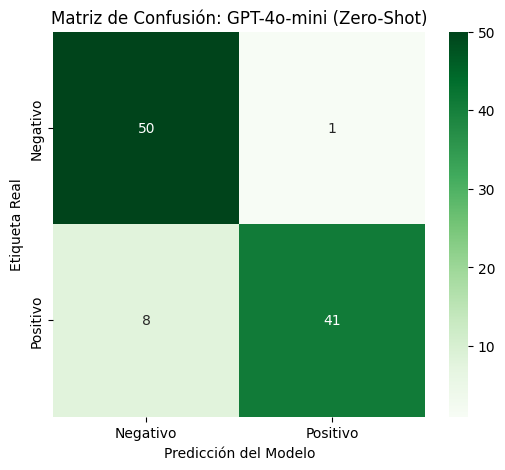

In [37]:
cm_gpt = confusion_matrix(y_true, y_pred_gpt)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_gpt, annot=True, fmt='d', cmap='Greens', 
            xticklabels=["Negativo", "Positivo"], 
            yticklabels=["Negativo", "Positivo"])
plt.title("Matriz de Confusión: GPT-4o-mini (Zero-Shot)")
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción del Modelo')
plt.show()